In [1]:
import sklearn
from sklearn import datasets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
intakes = pd.read_csv('Austin_Animal_Center_Intakes.csv',parse_dates=['DateTime','MonthYear'])
intakes.columns = intakes.columns.str.replace(" ","_")

In [3]:
outcomes = pd.read_csv('Austin_Animal_Center_Outcomes.csv',parse_dates=['DateTime','MonthYear','Date of Birth'])
outcomes.columns = outcomes.columns.str.replace(' ','_')

In [4]:
outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123983 entries, 0 to 123982
Data columns (total 12 columns):
Animal_ID           123983 non-null object
Name                85041 non-null object
DateTime            123983 non-null datetime64[ns]
MonthYear           123983 non-null datetime64[ns]
Date_of_Birth       123983 non-null datetime64[ns]
Outcome_Type        123971 non-null object
Outcome_Subtype     57054 non-null object
Animal_Type         123983 non-null object
Sex_upon_Outcome    123982 non-null object
Age_upon_Outcome    123982 non-null object
Breed               123983 non-null object
Color               123983 non-null object
dtypes: datetime64[ns](3), object(9)
memory usage: 11.4+ MB


In [5]:
intakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123645 entries, 0 to 123644
Data columns (total 12 columns):
Animal_ID           123645 non-null object
Name                84669 non-null object
DateTime            123645 non-null datetime64[ns]
MonthYear           123645 non-null datetime64[ns]
Found_Location      123645 non-null object
Intake_Type         123645 non-null object
Intake_Condition    123645 non-null object
Animal_Type         123645 non-null object
Sex_upon_Intake     123644 non-null object
Age_upon_Intake     123645 non-null object
Breed               123645 non-null object
Color               123645 non-null object
dtypes: datetime64[ns](2), object(10)
memory usage: 11.3+ MB


In [6]:
col_intersect = sorted(list(set(intakes.columns).intersection(set(outcomes.columns))))
col_intersect.remove("DateTime")
col_intersect.remove("MonthYear")

In [7]:
print("intakes:    ",len(intakes))
print("outcomes:   ",len(outcomes))
print("total rows: ", len(intakes)+len(outcomes))
print("unique #:   ", len(pd.merge(intakes, outcomes, how='inner', on=col_intersect)))

intakes:     123645
outcomes:    123983
total rows:  247628
unique #:    159728


In [78]:
df = pd.merge(intakes, outcomes, on=col_intersect,suffixes=('_in', '_out') )
df.sort_index(axis=1,inplace=True)

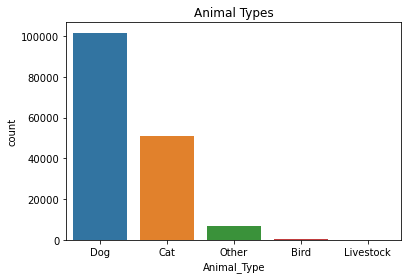

In [79]:
sns.countplot(x='Animal_Type', data=df)
plt.title('Animal Types')
plt.show()

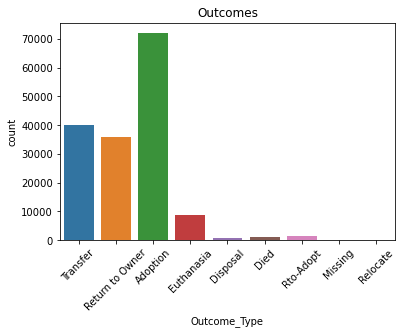

In [80]:
ax = sns.countplot(x='Outcome_Type', data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.title('Outcomes')
plt.show()

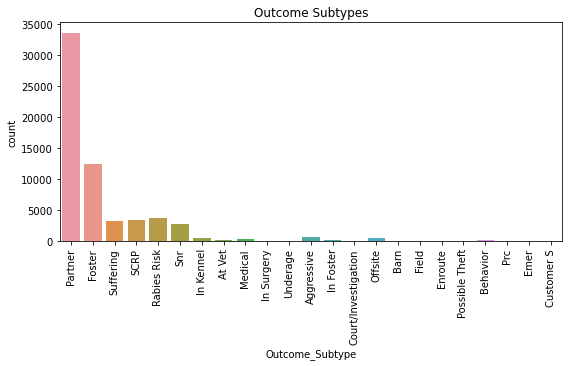

In [81]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x='Outcome_Subtype', data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.tight_layout()
plt.title('Outcome Subtypes')
plt.show()

In [82]:
df.drop(index=df[df.Age_upon_Outcome.isna()==True].index, inplace=True)
#MONTHYEAR IS SAME AS DATETIME
df.drop(columns=['MonthYear_in', 'MonthYear_out'],inplace=True)

In [83]:
# LOOK FOR WHEN DATETIME_IN IS EARLIER THAN DATE_OF_BIRTH
wrong_dob = (df.Date_of_Birth > df.DateTime_in)
#likely reasoning is DateTime_in is when the mother was brought into the center and the DOB is when the babies were born
#given this assumption, change all DateTime_in to DOB 
df.loc[wrong_dob, ['DateTime_in']] = df.loc[wrong_dob, ['Date_of_Birth']].values

In [84]:
# LOOK FOR AND SWITCH WHEN DATETIME_IN IS LATER THAN DATETIME_OUT
idx = (df.DateTime_out<df.DateTime_in)
#IF IN IS LATER THAN OUT, SWTICH
df.loc[idx,['DateTime_out','DateTime_in']] = df.loc[idx,['DateTime_in','DateTime_out']].values
#AGES APPEAR TO BE SWITCHED FOR ALL OF THESE OBSERVATIONS AS WELL. SWITCH THESE TWO COLUMNS
df.loc[idx,['Age_upon_Outcome', 'Age_upon_Intake']] = df.loc[idx,['Age_upon_Intake', 'Age_upon_Outcome']].values

In [85]:
# CREATE A TRUE DURATION IN DAYS FOR IN/OUT 
df['Duration_Days']= (df.DateTime_out - df.DateTime_in).dt.days 

#GIVEN AGES AREN'T RELIABLE. 
#CALCULATE AGE UPON INTAKE USING DATE OF BIRTH AND DATETIMEIN
#CALCULATE AGE UPON OUTCOME USING DATE OF BIRTH AND DATETIMEOUT
df['Calc_Age_In'] = round((df['DateTime_in'] - df['Date_of_Birth'])/ np.timedelta64(1, 'Y'),1)
df['Calc_Age_Out'] = round((df['DateTime_out'] - df['Date_of_Birth'])/ np.timedelta64(1, 'Y'),1)

In [86]:
#Create Alternative to Altered Status + Sex in each intake and outcome 
df['Altered'] = df['Sex_upon_Intake']!=df['Sex_upon_Outcome']
df['Sex'] = df.Sex_upon_Intake.str.split(" ").str[-1]
#Can drop sex_upon_ columns 

In [87]:
df.sort_index(axis=1,inplace=True)

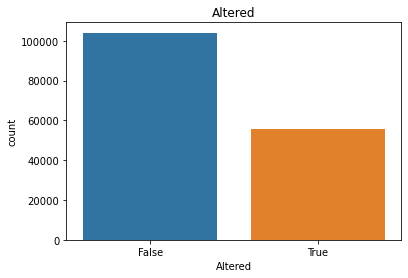

In [88]:
sns.countplot(x='Altered', data=df)
plt.title('Altered')
plt.show()

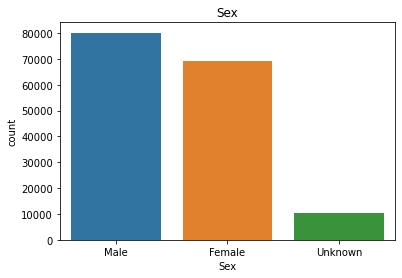

In [89]:
sns.countplot(x='Sex', data=df)
plt.title('Sex')
plt.show()

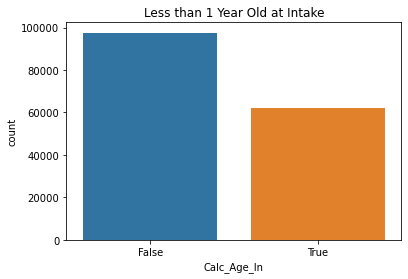

In [92]:
sns.countplot(df['Calc_Age_In'] <1)
plt.title('Less than 1 Year Old at Intake')
plt.show()

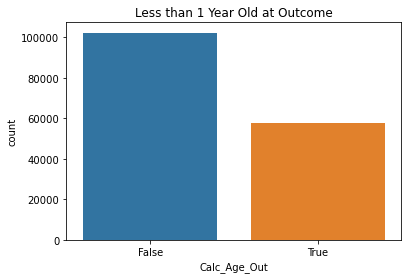

In [93]:
sns.countplot(df['Calc_Age_Out'] <1)
plt.title('Less than 1 Year Old at Outcome')
plt.show()

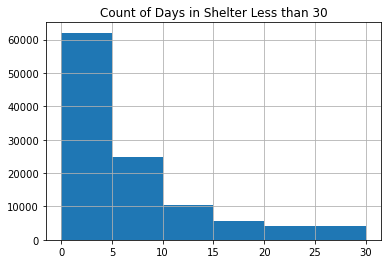

In [102]:
df['Duration_Days'].hist(bins=6,range=(0,30))
plt.title('Count of Days in Shelter Less than 30')
plt.show()

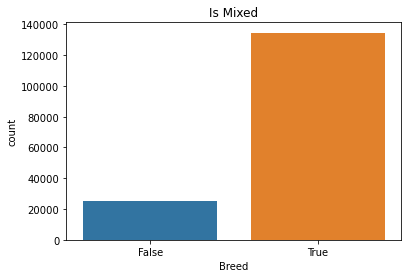

In [118]:
sns.countplot(df.Breed.str.contains("Mix|/"))
plt.title("Is Mixed")
plt.show()

In [121]:
df[df['Breed'].str.contains("-")].Animal_Type.value_counts()
#"-" in Breed doesn't mean mixed 
# "-" is only in "other" animal types

Other    71
Name: Animal_Type, dtype: int64

In [187]:
dog = df[df.Animal_Type=="Dog"]